In [2]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

import sys
sys.path.append('../')


'''An SE(A)IR model described the paper:
Bayesian particle filter algorithm for learning epidemic dynamics 
Calvetti et. al. '''

'''The model dynamics are designed for COVID, with SEAIRD dynamics. Given the absence of additional time series information, 
they combine the E and A compartments into a single compartment denoted E(A)'''


beta_par = {'beta_0':0.4,'beta_inf':0.1,'T':20,'tau':5} #hyperparameters for the functional form of beta

'''Functional beta'''
def beta(t,beta_par):

    if(t<beta_par['T']):
        return beta_par['beta_0']

    return beta_par['beta_inf'] + (beta_par['beta_0'] - beta_par['beta_inf']) * np.exp(-(t-beta_par['T'])/beta_par['tau'])
    

'''Model parameters'''
params = {'beta':lambda t: beta(t,beta_par),'eta':1/7,'gamma':1/14,'mu':0.004,'N_p':100_000, 'q':0.1}


def RHS(t,y,par): 
    S,E,I,R,_ = y
    dS = - par['beta'](t) * ((E + par['q'] * I)/par['N_p']) * S
    dE = par['beta'](t) * ((E + par['q'] * I)/par['N_p']) * S - par['eta']*E - par['gamma'] * E
    dI = par['eta'] * E - par['gamma'] * I - par['mu'] * I
    dR = par['gamma'] * E + par['gamma'] * I

    d_newI = par['eta'] * E

    return np.array([dS,dE,dI,dR,d_newI])





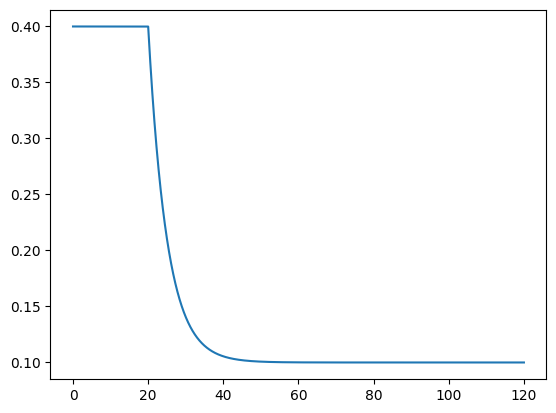

In [3]:
'''Plots the functional form of beta(t), negative exponential'''

beta_ts = np.linspace(0,120,120000)

betas = []
for i in range(np.shape(beta_ts)[0]):
    betas.append(beta(beta_ts[i],beta_par))

plt.plot(beta_ts,np.array(betas))


In [4]:
t_span = [0,120]
initial_infected = 2
y0 = [params['N_p'] - initial_infected-initial_infected,initial_infected,initial_infected,0,0]

'''Default solver is RK-45

Solves the ODE system for Protocol A, gamma = 1/14, eta = 1/7

'''
sol = solve_ivp(fun=lambda t,y: RHS(t,y,params),t_span = t_span,y0 = y0,t_eval = np.linspace(0,120,120))





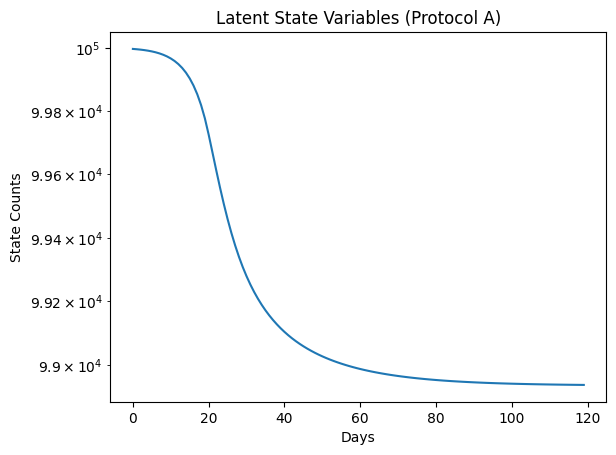

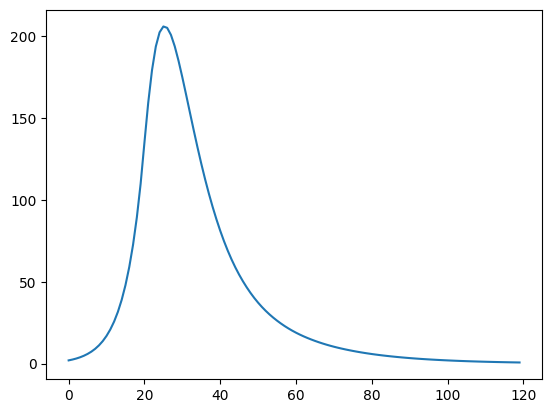

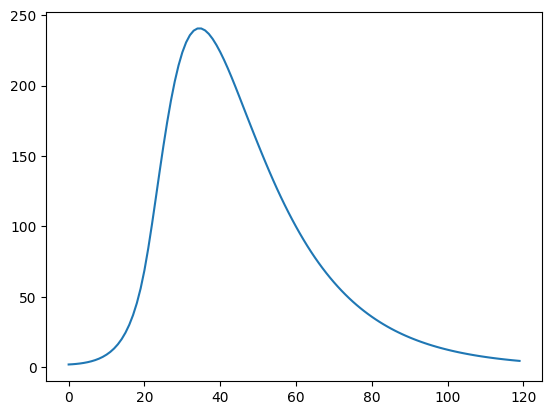

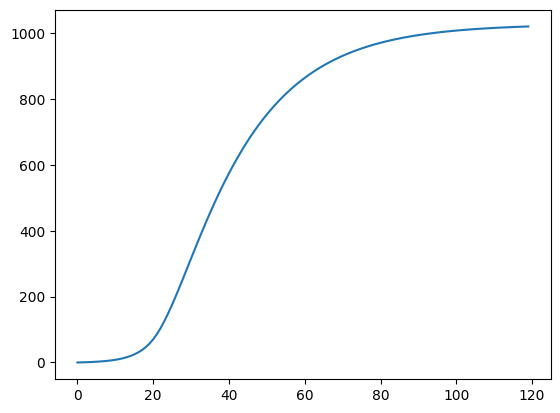

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


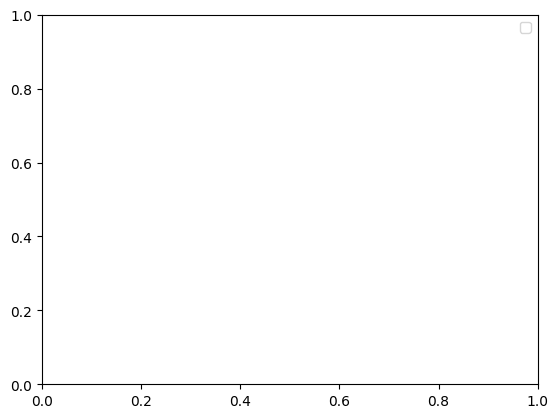

In [5]:
'''Plotting for the state variables'''

plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('State Counts')
plt.title('Latent State Variables (Protocol A)')
labels = ['S','E','I','R']
for i in range(4):
    plt.plot(sol.y[i,:],label = labels[i])
    plt.show()
plt.legend()



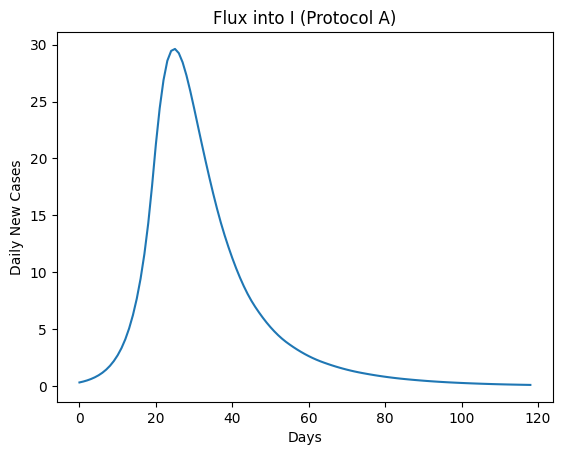

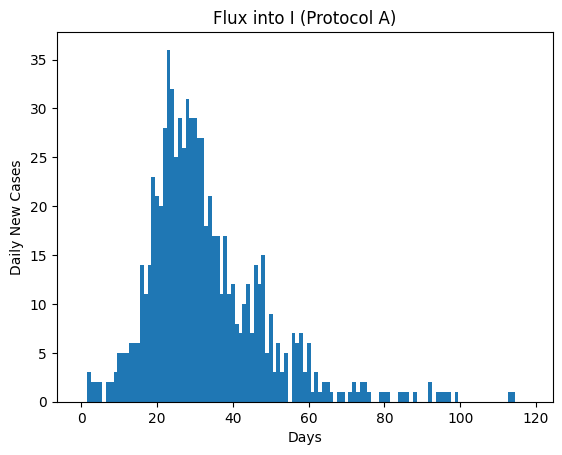

In [6]:
import pandas as pd

'''Plotting for the flux ->I'''
plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')
plt.plot(np.diff(sol.y[4,:]))
plt.show()

'''Plotting for the Poisson samples centered at the flux ->I'''

flux = np.diff(sol.y[4,:])
#flux = sol.y[2,:]
rng = np.random.default_rng()

sim_data = rng.poisson(flux) 

pd.DataFrame(sim_data).to_csv('../datasets/calvetti_sim_data_protocol_A.csv')

plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')
plt.bar(x=np.arange(0,np.shape(flux)[0]),height = sim_data,width=1)
#plt.plot(flux,zorder=2,color='red')
plt.show()




The ->I flux from Calvetti et. al.  

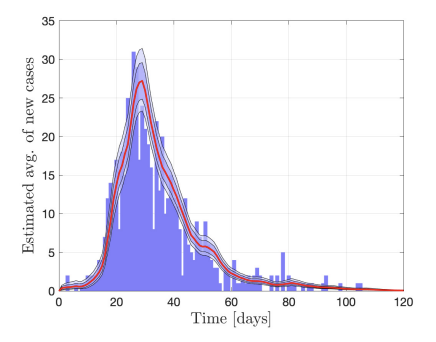

In [7]:
'''Entry point for the particle filtering code '''

from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.resamplers.resamplers import PoissonResample,LogNBinomResample
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver
from Implementations.perturbers.perturbers import MultivariatePerturbations,LogMultivariatePerturbations
from utilities.Utils import Context,ESTIMATION
from functools import partial


'''Algorithm object encapsulating all the requirements'''
algo = TimeDependentAlgo(integrator = LSODACalvettiSolver(),
                        perturb = MultivariatePerturbations(hyper_params={"h":0.1,"sigma1":0.01,"sigma2":0.1}),
                        resampler = PoissonResample(),
                        ctx=Context(population=100_000,
                                    state_size = 4,
                                    weights=np.zeros(1000),
                                    seed_loc=[1,2],
                                    seed_size=0.00005,
                                    forward_estimation=1,
                                    rng=np.random.default_rng(),
                        particle_count=1000))

algo.initialize(params={
"beta":ESTIMATION.VARIABLE,
"gamma":1/14,
"eta":1/7,
"mu":0.004,
"q":0.1,
"R":100,
"alpha":0.1,
}


,priors={"beta":partial(algo.ctx.rng.uniform,0.1,0.6), 
          "gamma":partial(algo.ctx.rng.uniform,1/28,1/7),
          "eta":partial(algo.ctx.rng.uniform,1/15,1/3),
          "q":partial(algo.ctx.rng.uniform,0,0.5)
          })

'''Runs the PF over the specified data set for the specified length of time'''

#algo.print_particles()
algo.run(f'../datasets/calvetti_sim_data_protocol_A.csv',119)





beta: 0.3744588483949095
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 0
beta: 0.4328506478062615
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 1
beta: 0.39090229833874934
gamma: 0.07142857142857144
eta: 0.14285714285714288
Iteration: 2
beta: 0.3617293578237343
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 3
beta: 0.905222013469495
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 4
beta: 2.969761348622899
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 5
beta: 4.038704670536397
gamma: 0.07142857142857141
eta: 0.14285714285714282
Iteration: 6
beta: 4.433900147756653
gamma: 0.07142857142857144
eta: 0.14285714285714288
Iteration: 7
beta: 4.599337110093877
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 8
beta: 4.567274416086403
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 9
beta: 4.699460286048724
gamma: 0.07142857142857142
eta: 0.14285714285714285
Iteration: 10
beta: 4.8128808

Simulated beta for Protocol A



IndexError: index 3 is out of bounds for axis 1 with size 0

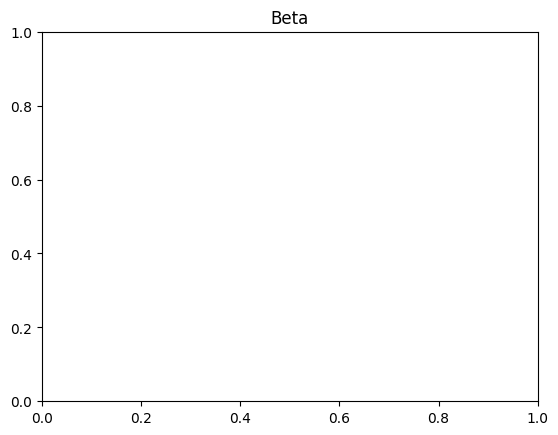

In [8]:
pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1)
beta_quantiles = pd.read_csv('../datasets/beta_quantiles.csv').to_numpy()
beta_quantiles = np.delete(beta_quantiles,0,1)

pf_eta = pd.read_csv('../datasets/average_eta.csv').to_numpy()
pf_eta = np.delete(pf_eta,0,1)
eta_quantiles = pd.read_csv('../datasets/eta_quantiles.csv').to_numpy()
eta_quantiles = np.delete(eta_quantiles,0,1)

pf_gamma = pd.read_csv('../datasets/average_gamma.csv').to_numpy()
pf_gamma = np.delete(pf_gamma,0,1)
gamma_quantiles = pd.read_csv('../datasets/gamma_quantiles.csv').to_numpy()
gamma_quantiles = np.delete(gamma_quantiles,0,1)

pf_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)


plt.title("Beta")

plt.fill_between(np.arange(0,119), beta_quantiles[:,3], beta_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,119), beta_quantiles[:,6], beta_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)

plt.plot(pf_beta,color="red",zorder=12)
plt.plot(beta_ts,np.array(betas),linestyle="dashed",zorder=12,color='black')
plt.savefig('Beta.png')
plt.show()

plt.title("Eta")

plt.fill_between(np.arange(0,119), eta_quantiles[:,3], eta_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,119), eta_quantiles[:,6], eta_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)
plt.plot(pf_eta,color="red",zorder=12)

plt.plot([1/7 for _ in range(120)],linestyle="dashed",color='black',zorder=12)
plt.savefig('Eta.png')
plt.show()

plt.title("Gamma")

plt.fill_between(np.arange(0,119), gamma_quantiles[:,3], gamma_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,119), gamma_quantiles[:,6], gamma_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)
plt.plot(pf_gamma,color="red",zorder=12)


plt.plot([1/14 for _ in range(120)],linestyle="dashed",color='black',zorder=12)
plt.savefig('Gamma.png')
plt.show()

plt.yscale('log')
plt.title("State")

labels = ['S','E','I','R']
plt.xlabel("Days")
for i in range(4):
    plt.plot(sol.y[i,:],label = labels[i],alpha = 0.3)
    plt.plot(pf_state[:,i])
plt.legend()
plt.show()

plt.savefig('State.png')

